In [1]:
import pandas as pd
import seaborn as sns
#sns.set(font_scale=1)
sns.set_style("whitegrid")
#sns.set_style("darkgrid")
#sns.set_context("poster")
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
%matplotlib inline
import sys
import os
from scipy.optimize import newton, minimize, fsolve
import numpy as np
import copy
import re

import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])

import random

In [2]:
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [3]:
palette = sns.color_palette(as_cmap=True)

In [4]:
AA_keys = ['Alanine pos', 'Arginine pos', 'Asparagine pos', 'Aspartate neg', 'Cystine pos', 'Glutamate neg', 'Glutamine pos', 'Glycine neg', 'Isoleucine pos', 'Leucine pos', 'Lysine pos', 'Methionine pos', 'Phenylalanine pos', 'Proline pos', 'Serine neg', 'Threonine pos', 'Tryptophan pos', 'Tyrosine pos', 'Valine pos']


GAUCT_keys = ['Guanine pos', 'Adenine pos', 'Uracil neg', 'Cytosine pos', 'Hypoxanthine pos']
pool14_keys = ['Adenosine pos', 'Deoxythymidine neg', 'Deoxycytidine pos', 'Deoxyuridine neg', 'Cytidine pos', 'Guanosine pos', 'Uridine pos']
cell_keys = ['Adenosine pos', 'Deoxythymidine neg', 'Deoxycytidine pos', 'Cytidine pos', 'Guanosine pos', 'Uridine neg']
nucl_breakdown_keys = GAUCT_keys + ['Uric acid neg', 'Xanthine neg', 'Glycine neg']

In [5]:
### Read measurements

annotation_df = pd.read_excel('annotations.xlsx')

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('nucleotide_acid-hydrolysis_temp-opti.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        ### Turned on
        if sum(metab_dict_mes[k]['Response Ratio']) != 0 and True:
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = metab_dict_mes[k]['Sample ID']
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'Response Ratio', 'Sample ID', 'Flag Details'], axis=1)


df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']

In [6]:
df

,Sample_name,Replicate,Content,Hydrolysis temperature,Adenine pos,Adenosine pos,Aspartate neg,Cytidine pos,Cytosine pos,Deoxycytidine pos,...,Hypoxanthine pos,Inosine pos,Phenylalanine pos,Proline pos,Tyrosine pos,Uracil neg,Uric acid neg,Uridine neg,Uridine pos,Xanthine neg
0,H01,1,Pool 14,Control,118.685,6802.196,0.000,4356.829,0.000,75.203,...,0.077,21613230,0.039,0.001,0.385,955.941,0.017,1148.497,0.750,0.073
1,H02,2,Pool 14,Control,127.365,9914.584,0.000,4026.767,0.000,72.328,...,0.087,18527784,0.040,0.001,0.372,1055.753,0.000,1121.859,0.681,0.000
2,H03,1,Pool 14,70C,880.276,0.328,0.000,3021.745,1451.813,10.659,...,4.139,0,0.064,0.002,0.412,2075.568,0.061,1011.478,0.496,3.447
3,H04,2,Pool 14,70C,867.122,0.092,0.000,3292.525,1515.226,9.033,...,5.093,0,0.055,0.002,0.370,1963.618,0.000,244.382,0.612,3.684
4,H05,1,Pool 14,80C,769.103,0.023,0.003,4151.582,1890.771,0.011,...,6.762,0,0.060,0.003,0.338,2042.762,0.000,1060.314,0.462,12.641
5,H06,2,Pool 14,80C,796.101,0.030,0.000,4066.123,1780.121,0.010,...,6.788,0,0.115,0.004,0.370,2056.980,0.000,997.473,0.478,11.280
6,H07,1,Pool 14,90C,917.386,0.012,0.004,4732.806,2332.533,0.000,...,17.460,0,0.160,0.012,0.414,2815.408,0.145,871.814,0.322,41.374
7,H08,2,Pool 14,90C,890.961,0.009,0.006,5194.057,2398.067,0.000,...,15.789,0,0.187,0.014,0.434,2009.253,0.054,695.545,0.340,36.788
8,H09,1,Cells,Control,1.861,1.450,3.911,0.969,1.874,0.013,...,0.000,0,7.965,0.412,13.320,1.154,1.278,0.188,0.000,0.172
9,H10,2,Cells,Control,0.870,1.549,3.973,0.380,0.440,0.011,...,0.008,0,8.347,0.411,13.858,0.000,1.659,0.000,0.000,0.170


In [7]:
### Show degradation of nucleosides after acid incubation of Pool 14 ###
mask = (df['Content'] == 'Pool 14')
df_AA = df[mask]

metab_mask = ['Hydrolysis temperature'] + pool14_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Hydrolysis temperature']
for metab in pool14_keys:
    mask_norm = df_metab['Hydrolysis temperature'] == 'Control'
    metab_name = metab[0:-4]
    metab_norm_mean = df_metab.loc[mask_norm, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_norm_mean
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Hydrolysis temperature']).rename(columns={'variable': 'Nucleoside', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

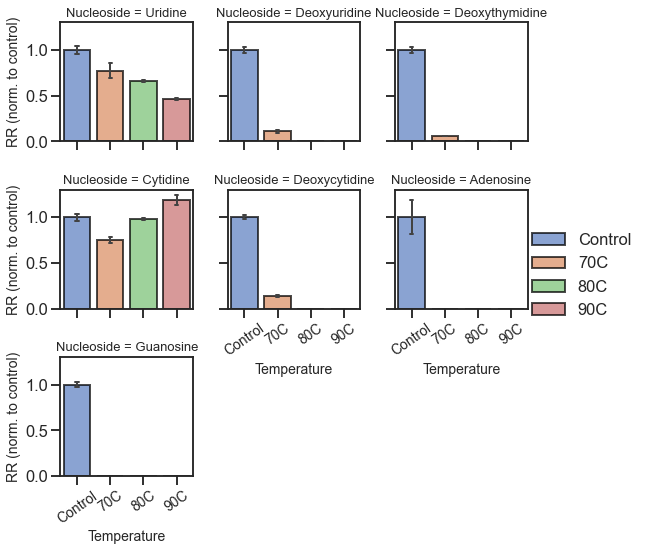

In [8]:
plot_name = 'Pool-14-temp_nucleoside-stability.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

col_order = ['Uridine', 'Deoxyuridine', 'Deoxythymidine', 'Cytidine', 'Deoxycytidine', 'Adenosine', 'Guanosine']
sns_fig = sns.FacetGrid(df_metab_flat, col='Nucleoside', height=2.5, col_wrap=3, despine=False, col_order=col_order)
sns_fig.map_dataframe(sns.barplot, x='Hydrolysis temperature', y='Peak area', ci=90, hue='Hydrolysis temperature', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Temperature', 'RR (norm. to control)', size=14)
sns_fig.set_xticklabels(size=14, rotation=35)
sns_fig.set_titles(size=13)
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [9]:
### Show appearance of nucleobases after acid incubation of Pool 14 ###
mask = (df['Content'] == 'Pool 14')
df_AA = df[mask]

metab_mask = ['Hydrolysis temperature'] + nucl_breakdown_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Hydrolysis temperature']
for metab in nucl_breakdown_keys:
    mask_norm = df_metab['Hydrolysis temperature'] == '90C'
    metab_name = metab[0:-4]
    metab_norm_mean = df_metab.loc[mask_norm, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_norm_mean
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Hydrolysis temperature']).rename(columns={'variable': 'Nucleobase', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

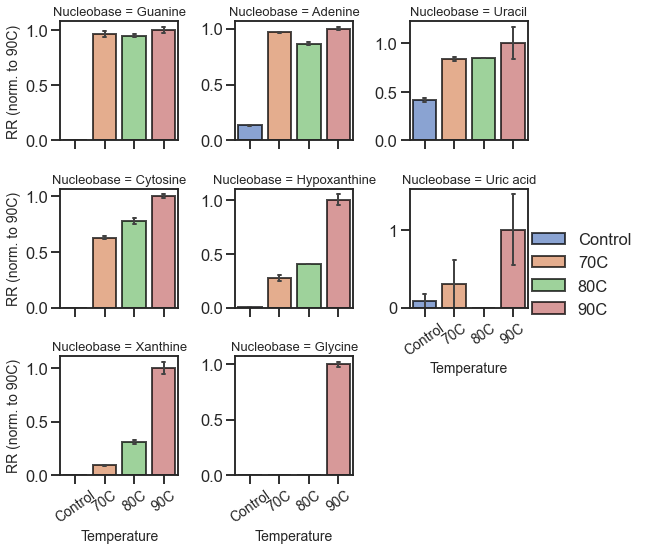

In [10]:
plot_name = 'Pool-14-temp_nucleobase-release.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()

sns_fig = sns.FacetGrid(df_metab_flat, col='Nucleobase', height=2.5, col_wrap=3, despine=False, sharey=False)
sns_fig.map_dataframe(sns.barplot, x='Hydrolysis temperature', y='Peak area', ci=90, hue='Hydrolysis temperature', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Temperature', 'RR (norm. to 90C)', size=14)
sns_fig.set_xticklabels(size=14, rotation=35)
sns_fig.set_titles(size=13)
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

<Figure size 432x288 with 0 Axes>

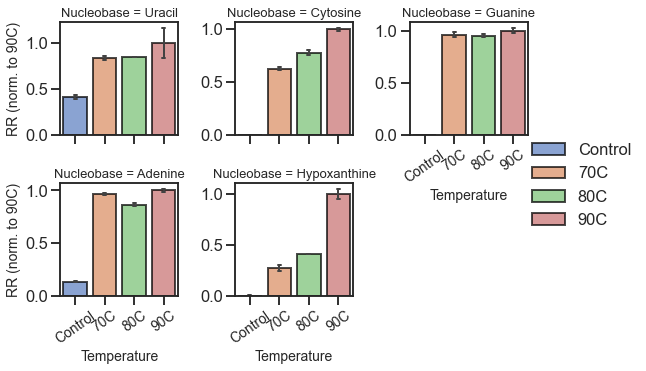

In [11]:
plot_name = 'Pool-14-temp_nucleobase-release_2.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()
col_order = ['Uracil', 'Cytosine', 'Guanine', 'Adenine', 'Hypoxanthine']
mask = (df_metab_flat['Nucleobase'] != 'Glycine') & (df_metab_flat['Nucleobase'] != 'Xanthine') & (df_metab_flat['Nucleobase'] != 'Uric acid')
sns_fig = sns.FacetGrid(df_metab_flat[mask], col='Nucleobase', height=2.5, col_wrap=3, despine=False, sharey=False, col_order=col_order)
sns_fig.map_dataframe(sns.barplot, x='Hydrolysis temperature', y='Peak area', ci=90, hue='Hydrolysis temperature', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Temperature', 'RR (norm. to 90C)', size=14)
sns_fig.set_xticklabels(size=14, rotation=35)
sns_fig.set_titles(size=13)
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [12]:
### Show degradation of nucleosides after acid incubation of whole cell extract ###
mask = (df['Content'] == 'Cells')
df_AA = df[mask]

metab_mask = ['Hydrolysis temperature'] + cell_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Hydrolysis temperature']
for metab in cell_keys:
    mask_norm = df_metab['Hydrolysis temperature'] == '70C'
    metab_name = metab[0:-4]
    metab_norm_mean = df_metab.loc[mask_norm, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_norm_mean
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Hydrolysis temperature']).rename(columns={'variable': 'Nucleoside', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

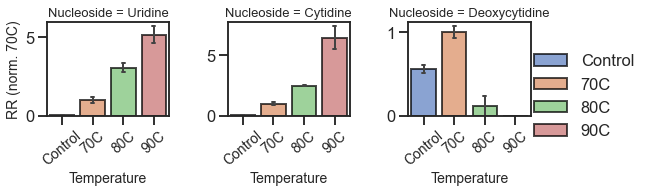

In [13]:
plot_name = 'whole-cell-temp_nucleoside-stability.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()
col_order = ['Uridine', 'Cytidine', 'Deoxycytidine']
sns_fig = sns.FacetGrid(df_metab_flat, col='Nucleoside', height=2.5, col_wrap=3, despine=False, sharey=False, col_order=col_order)
sns_fig.map_dataframe(sns.barplot, x='Hydrolysis temperature', y='Peak area', ci=90, hue='Hydrolysis temperature', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Temperature', 'RR (norm. 70C)', size=14)
sns_fig.set_xticklabels(size=14, rotation=40)
sns_fig.set_titles(size=13)
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [14]:
### Show appearance of nucleobases after acid incubation of whole cell extract ###
mask = (df['Content'] == 'Cells')
df_AA = df[mask]

metab_mask = ['Hydrolysis temperature'] + nucl_breakdown_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Hydrolysis temperature']
for metab in nucl_breakdown_keys:
    mask_norm = df_metab['Hydrolysis temperature'] == '90C'
    metab_name = metab[0:-4]
    metab_norm_mean = df_metab.loc[mask_norm, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_norm_mean
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Hydrolysis temperature']).rename(columns={'variable': 'Nucleobase', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

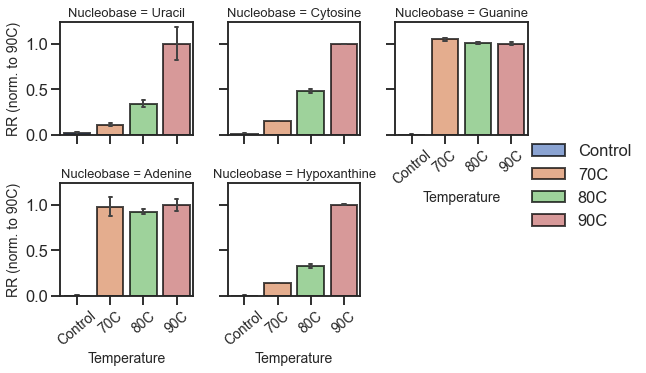

In [15]:
plot_name = 'whole-cell-temp_nucleobase-release.pdf'
pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()
col_order = ['Uracil', 'Cytosine', 'Guanine', 'Adenine', 'Hypoxanthine']
sns_fig = sns.FacetGrid(df_metab_flat, col='Nucleobase', height=2.5, col_wrap=3, despine=False, col_order=col_order)
sns_fig.map_dataframe(sns.barplot, x='Hydrolysis temperature', y='Peak area', ci=90, hue='Hydrolysis temperature', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Temperature', 'RR (norm. to 90C)', size=14)
sns_fig.set_xticklabels(size=14, rotation=40)
sns_fig.set_titles(size=13)
sns_fig.add_legend()


pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
pdf_plot.close()

In [30]:
df.columns

Index(['Sample_name', 'Replicate', 'Content', 'Hydrolysis temperature',
       'Adenine pos', 'Adenosine pos', 'Aspartate neg', 'Cytidine pos',
       'Cytosine pos', 'Deoxycytidine pos', 'Deoxythymidine neg',
       'Deoxyuridine neg', 'Glycine neg', 'Guanine pos', 'Guanosine pos',
       'Hypoxanthine pos', 'Inosine pos', 'Phenylalanine pos', 'Proline pos',
       'Tyrosine pos', 'Uracil neg', 'Uric acid neg', 'Uridine neg',
       'Uridine pos', 'Xanthine neg'],
      dtype='object')

In [26]:
df_AA.loc[:, 'Alanine pos']

KeyError: 'Alanine pos'

In [31]:
AA_keys = ['Aspartate neg', 'Glycine neg', 'Phenylalanine pos', 'Proline pos', 'Tyrosine pos']

In [33]:
### Show degradation of amino acids after acid incubation of whole cell extract ###
mask = (df['Content'] == 'Cells')
df_AA = df[mask]

metab_mask = ['Hydrolysis temperature'] + AA_keys
df_metab = df_AA.loc[:, metab_mask]

metab_mask = ['Hydrolysis temperature']
for metab in AA_keys:
    mask_norm = df_metab['Hydrolysis temperature'] == '70C'
    metab_name = metab[0:-4]
    metab_norm_mean = df_metab.loc[mask_norm, metab].mean()
    df_metab[metab_name] = df_metab[metab] / metab_norm_mean
    metab_mask.append(metab_name)

df_metab = df_metab.loc[:, metab_mask]

df_metab_flat = pd.melt(df_metab, id_vars=['Hydrolysis temperature']).rename(columns={'variable': 'AA', 'value': 'Peak area'})

<Figure size 432x288 with 0 Axes>

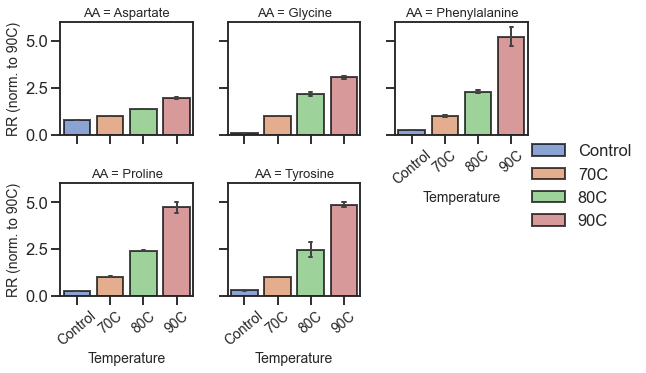

In [34]:
#plot_name = 'whole-cell-temp_nucleobase-release.pdf'
#pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)

fig = plt.figure()
#col_order = ['Uracil', 'Cytosine', 'Guanine', 'Adenine', 'Hypoxanthine']
sns_fig = sns.FacetGrid(df_metab_flat, col='AA', height=2.5, col_wrap=3, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Hydrolysis temperature', y='Peak area', ci=90, hue='Hydrolysis temperature', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Temperature', 'RR (norm. to 90C)', size=14)
sns_fig.set_xticklabels(size=14, rotation=40)
sns_fig.set_titles(size=13)
sns_fig.add_legend()


#pdf_plot.savefig(sns_fig.fig, bbox_inches='tight')
plt.show()
#pdf_plot.close()